In [37]:
%matplotlib inline

from __future__ import print_function, division

import os, sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, interact_manual
from ipywidgets import FloatSlider, IntSlider, Dropdown
from ipywidgets import Checkbox, RadioButtons, fixed 

from IPython.display import display, clear_output


from astropy.convolution import convolve, Gaussian1DKernel

import seaborn as sns
sns.set(context="poster", font_scale=1.5)

# from bokeh import mpl
# from bokeh.plotting import show, output_notebook
# output_notebook()


## import from local files

## Boilerplate path hack to give access to full SNe package
import sys
if __package__ is None:
    if os.pardir not in sys.path[0]:
        file_dir = os.getcwd()
        sys.path.insert(0, os.path.join(file_dir, 
                                        os.pardir, 
                                        os.pardir))

from SNe.analysis.constants import m_proton, pc, yr, M_solar, \
                                   gamma, E_0, metallicity_solar
    
from SNe.analysis.sedov.dimensionalize_sedov import dimensionalized_sedov
from SNe.analysis.sedov.closed_form_sedov import SedovSolution
from SNe.analysis.parameter_study_file_structure import make_dirname_from_properties
from SNe.analysis.parse import RunSummary, parse_run, cols


general_exponential_format = "%.2e" # for formatting strings


In [79]:
class InnerWidget(object):
    """ 
        Allows a pointer to the single_run interact widget to be stored as a static variable
            - at some point I should find a better way to do this
    """
    def __init__(self):
        super(InnerWidget, self).__init__()
    w = None

    
#### These are needed for both the plotting and parsing routines    

cols_plot = cols 
cols_plot_linear = [cols[i] for i in [6, 10]]

label_dict = {"Radius"       :"$R$ [pc]", 
              "Velocity"     : r"$U$ [cm s$^{-1}$]",
              "Density"      : r"$\rho$  [g cm$^{-3}$]",
              "Temperature"  : r"$T$ [K]",
              "Mass"         : r"$M$ [$M_\odot$]",
              "M_int"        : r"$M_\mathrm{int}$ [$M_\odot$]",
              "C_ad"         : r"$C_{ad}$ [cm s$^{-1}$]",
              "Crossing_time": r"$dt_{\mathrm{crossing}}$",
              "Energy"       : r"$E_{int}$ [erg g$^{-1}$]",
              "Pressure"     : r"$P$ [dyne cm$^{-2}$]",
              "Entropy"      : r"$S$ [$k_B$ / particle]",
              "M_int"        : r"$M_{int}$ [$M_\odot$]",
              "dR"           : r"$\Delta R$ [cm]",
              "dV"           : r"$\Delta V$ [cm$^3$]",
              "Z"            : r"$Z$ (metallicity)",
              "zones"        : r"zones"
             }

    
def plotter(last_run,
            checkpoint_filenames, 
            metallicity, background_density, background_temperature,
            sedov_solution,
            x_axis_variable  = "Radius",
            y_axis_variable  = "Density",
            with_Sedov       = True,
            highlight_timestep_limiting_cell = False,
            outer_limit_log  = 0, 
            checkpoint_index = 0,
            show_at_end=True):
    df_tmp = last_run.df.loc[checkpoint_index]

    checkpoint_filename = checkpoint_filenames[checkpoint_index]
    time = last_run.times[checkpoint_index]
    
    E_kin = sedov_solution.E_kin
    E_int = sedov_solution.E_int
    print("E_kin: ", general_exponential_format % E_kin)
    print("E_int: ", general_exponential_format % E_int)
    momentum = sedov_solution.get_momentum(time=time - last_run.times[0])

    print("checkpoint: ",
          checkpoint_filename)
    print("time:                      ",
          general_exponential_format % (time / yr), "[yr]",
          "\t", general_exponential_format % (time ), "[s]")
    print("time elapsed:              ",
          general_exponential_format % ((time - last_run.times[0]) / yr), "[yr]",
          "\t", general_exponential_format % ((time - last_run.times[0])), "[s]")

    if last_run.overview.SNe_times.size == 1:
        print("energy conserved to:       ", 
              general_exponential_format % ((last_run.E_tot[checkpoint_index] - last_run.E_tot[0]) / last_run.E_tot[0]))
        print("E_kin    accurate to:      ", 
              general_exponential_format % ((last_run.E_kin[checkpoint_index] - E_kin) / E_kin))
        print("momentum accurate to:      ", 
              general_exponential_format % ((last_run.momentum[checkpoint_index] - momentum) / momentum))
        # # DON'T USE E_INT AS A METRIC, since you accrete in thermal energy
    #     print("E_int accurate to:         ", 
    #           (last_run.E_int[checkpoint_index] - E_int) / E_int)
        print("Peak luminosity at checkpoint", np.argmax(last_run.times == last_run.t_0) )
        print("Peak luminosity at t_0 =   ",
              general_exponential_format % (last_run.t_0 / yr), "[yr]")
        print("t_f = 13 * t_0 =           ",
              general_exponential_format % (last_run.t_f / yr), "[yr]")
        print("R_shock =                  ",
              "%3.2f" % (last_run.R_shock[checkpoint_index] / pc), "[pc]")
        print("E_R_tot =                  ",
              general_exponential_format % last_run.E_R_tot[checkpoint_index], "[ergs]")
    print("background_density:        ", 
          general_exponential_format % last_run.overview.background_density)
    print("Cluster mass:              ", 
          general_exponential_format % (last_run.overview.cluster_mass / M_solar), "M_sol")
    print("Number of SNe so far:      ", np.sum(last_run.overview.SNe_times <= time))
    print("mass loss prescription:    ", last_run.overview.mass_loss)
    
    if x_axis_variable is "Radius":
        plt.xlim((0,10**outer_limit_log))
    if x_axis_variable is "M_int":
        plt.xlim((0,10**2))

    marker = "."
    plt.plot(df_tmp[x_axis_variable], df_tmp[y_axis_variable], 
             marker=marker,
             label="numeric",
             drawstyle="steps")
    if highlight_timestep_limiting_cell is True:
        timestep_limiting_index = df_tmp.Crossing_time.argmin()
        plt.plot(df_tmp[x_axis_variable].loc[timestep_limiting_index],
                 df_tmp[y_axis_variable].loc[timestep_limiting_index], 
                 marker=marker,
                 linestyle="",
                 label="Timestep limiting cell",
                 color='r')

    if y_axis_variable in cols_plot_linear:
        plt.yscale("linear")
    else:
        plt.yscale("log")
    # Set and fix limits
    y_min, y_max = plt.ylim()
    plt.ylim( (y_min / 5, y_max * 5) )
    if y_axis_variable is "Velocity":
        plt.ylim(ymin=1)
    
    if with_Sedov:
        plot_sedov(last_run, time, x_axis_variable, y_axis_variable, 
                   metallicity, background_density, background_temperature)
    
    plt.xlabel(label_dict[x_axis_variable])
    plt.ylabel(label_dict[y_axis_variable])

    plt.legend(loc="best")
    
    if show_at_end is True:
        plt.show() # until ipywidgets stops flickering for an output of None
    
def plot_sedov(last_run, time, x_axis_variable, y_axis_variable, 
               metallicity, background_density, background_temperature):

    sedov_x_axes = ["Radius", "M_int"]
    if x_axis_variable not in sedov_x_axes:
        return
    
    sedov_cols = ["Radius", "Velocity", "Density", "Temperature",
                  "C_ad", "Energy", "Pressure", "Entropy", "Mass"]
    sedov_cols_plot = sedov_cols[:-1]
    if y_axis_variable not in sedov_cols_plot:
        return
    
    sedov_time = time - last_run.overview.SNe_times[0]
    if sedov_time <= 0:
        return
    
    SNe_so_far = np.sum(last_run.overview.SNe_times <= time) 
    if SNe_so_far != 1:
        return
    
    sedov = dimensionalized_sedov(time - last_run.times[0],
                                  metallicity=metallicity, 
                                  background_density=background_density,
                                  background_temperature=background_temperature)
    sedov = np.array(sedov).transpose()
    df_sedov = pd.DataFrame.from_records(sedov, 
                                         columns=sedov_cols)
    df_sedov.Radius  /= pc
    df_sedov.Mass    /= M_solar
    df_sedov["M_int"] = df_sedov.Mass.cumsum()

    plt.plot(df_sedov[x_axis_variable], df_sedov[y_axis_variable], 
             label="analytic (no cooling)")
    
def single_run(data_dir="", id="", last_run=None, w=widgets.widget_box.Box):

    if not os.path.exists(data_dir):
        raise FileNotFoundError("No directory found named: "+ data_dir)
    
    if type(last_run) is not RunSummary:
        last_run = RunSummary()
    
    parse_results = parse_run(data_dir=data_dir, id=id, last_run=last_run)
    sedov_solution = SedovSolution(E_0,
                                   last_run.overview.background_density, 
                                   last_run.overview.metallicity)
    
    #### PASS TO PLOTTER ####
    num_checkpoints = len(parse_results.checkpoint_filenames)
    
    log_R_max = round(np.log10(last_run.df["Radius"].max()), 2)
    log_R_min = max(log_R_max-4, 
                    round(np.log10(last_run.df["Radius"].min()), 2)+1)
                
    if type(InnerWidget.w) is widgets.widget_box.Box:
        InnerWidget.w.close()

    w = interactive(plotter,
            last_run               = fixed(last_run),
            checkpoint_filenames   = fixed(parse_results.checkpoint_filenames),
            metallicity            = fixed(last_run.overview.metallicity),
            background_density     = fixed(last_run.overview.background_density),
            background_temperature = fixed(last_run.overview.background_temperature),
            sedov_solution         = fixed(sedov_solution),
            outer_limit_log        = FloatSlider(min=log_R_min, max=log_R_max, step=0.1, value=log_R_max),
            checkpoint_index       = IntSlider(min=0, max=num_checkpoints-1, step=0, value=num_checkpoints-1),
            y_axis_variable        = Dropdown(options=cols_plot, value="Density"),
            x_axis_variable        = RadioButtons(options=["Radius", "M_int", "zones"]),
            show_at_end            = fixed(True))


    InnerWidget.w = w
    display(w)
    return w

E_kin:  2.85e+50
E_int:  7.15e+50
checkpoint:  ../src/416B4960-4FD8-4909-AF40-022C5A0FE701_checkpoint_0097.dat
time:                       8.81e+06 [yr] 	 2.78e+14 [s]
time elapsed:               8.81e+06 [yr] 	 2.78e+14 [s]
background_density:         2.22e-24
Cluster mass:               1.00e+02 M_sol
Number of SNe so far:       1
mass loss prescription:     uniform


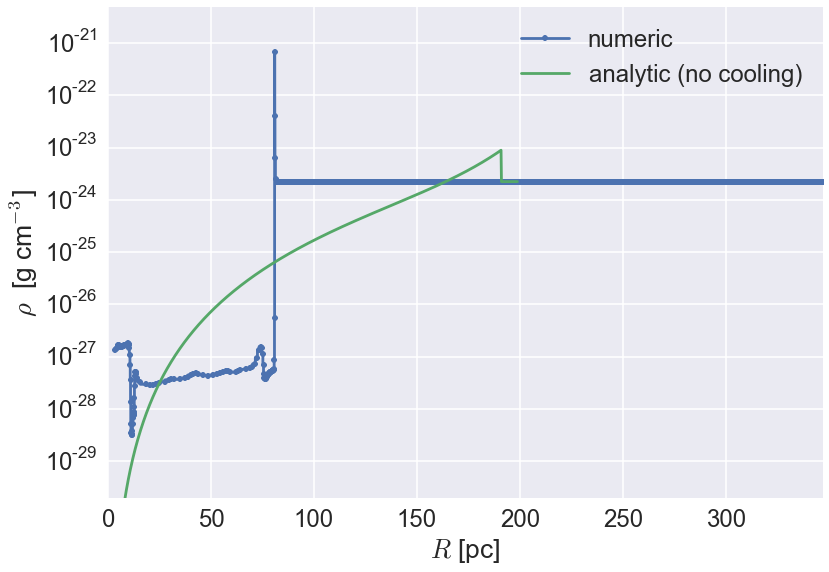

None

In [80]:
last_run = RunSummary()

data_dir = "../src/"
# data_dir = "../saved_runs/10_SNe_winds"

id = "" # you don't need the full uuid, just enough to distinguish it

w = single_run(data_dir=data_dir, id=id, last_run=last_run)

In [ ]:
last_run = RunSummary()


def parameter_study_wrapper(log_n, log_Z, T=1e4, 
                            with_cooling=True, 
                            last_run=last_run,
                            w = widgets.widget_box.Box()):
    z_solar = metallicity_solar
    
    background_density     = 1.33 * m_proton * 10**log_n
    metallicity            = z_solar * 10**log_Z
    background_temperature = T
    
    data_dir = make_dirname_from_properties( background_density, 
                                             metallicity, 
                                             background_temperature,
                                             with_cooling)
    w.close()
    if os.path.isdir(data_dir):
        tmp = glob.glob(data_dir + "*checkpoint*.dat")        
        
        if len(tmp) is not 0:
            basename = os.path.basename(tmp[0])
            id = basename.split("checkpoint")[0]
            
            w = single_run(data_dir=data_dir, id=id, last_run=last_run)
            
        else:
            print("No data was found")
    else:
        print("No directory was found")
        print("Directory: ", data_dir)

        
v = interact_manual(parameter_study_wrapper,
        log_Z = FloatSlider(min=-3.0, max=+0.5, step=0.5, value=0),
        log_n = FloatSlider(min=-3.0, max=+3.0, step=1.0, value=-1),
        T     = fixed(1e4),
        with_cooling = True, 
        last_run=fixed(last_run))

In [40]:
def SNe_distplot(last_run, x_axis):
    if x_axis is "time":
        x_data = last_run.overview.SNe_times / yr
        rug=True
        hist=False
    elif x_axis is "checkpoints":
        x_data = np.array([], dtype=np.int)
        
        for SNe_time in last_run.overview.SNe_times:
            if (SNe_time >= last_run.times.min()) and (SNe_time < last_run.times.max()):
                x_data = np.append(x_data, np.argmin(np.abs(last_run.times - SNe_time)))
        # this would be more natural as a histogram,
        # but I can't figure out how to normalize a histogram in a good way
        # Maybe it'd just be better to use subplots?
        rug=True
        hist=False
    else:
        raise ValueError("Unrecognized value for x_axis: " + x_axis )
    
    if x_data.size == 1:
        x_data = np.tile(x_data, 2) #seaborn can't do a rug plot of 1 point
    sns.distplot(x_data, color="k", norm_hist=False, 
                 hist=hist, rug=rug, kde=False, 
                 rug_kws={"linewidth":3},
                 bins=np.arange(last_run.times.size))

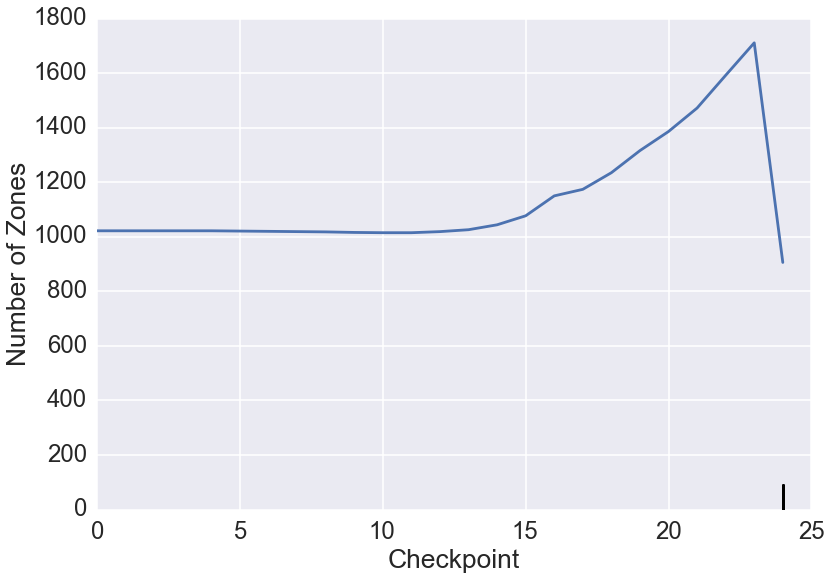

In [81]:
def plot_zones(last_run, distplot=True):
    if type(last_run) is RunSummary:
        if last_run.zones is not None:
            plt.plot(last_run.zones)
            plt.ylim(ymin=0)
            plt.ylabel("Number of Zones")
            plt.xlabel("Checkpoint")
            if distplot is True:
                SNe_distplot(last_run, "checkpoints")
            

plot_zones(last_run)

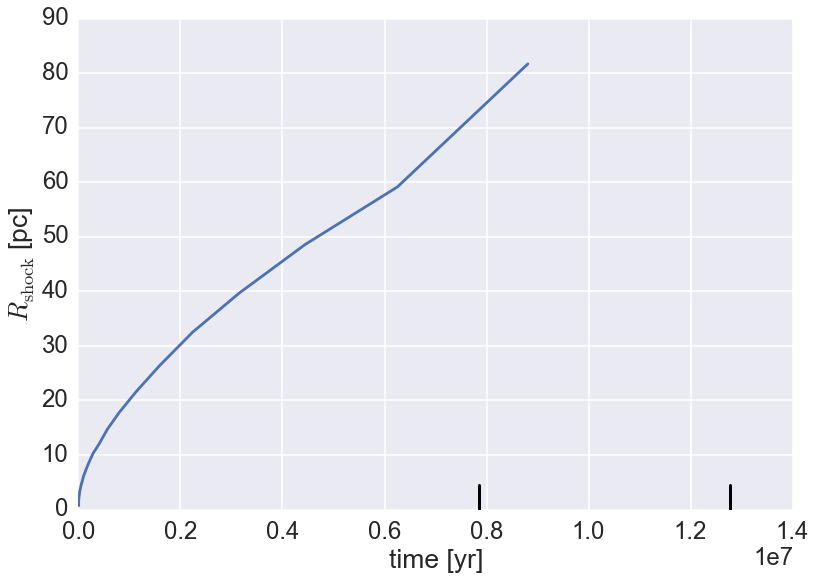

In [82]:
def shock_location_plot(last_run, clear_previous = True, distplot=True):
    if clear_previous:
        plt.figure()
    if distplot is True:
        SNe_distplot(last_run, "time")
    plt.plot(last_run.times / yr, last_run.R_shock / pc)
    plt.xlabel(r"time [yr]")
    plt.ylabel(r"$R_{\mathrm{shock}}$ [pc]")


#     plt.xscale("log")
#     plt.yscale("log")
shock_location_plot(last_run)

None

<function __main__.plot_energy>

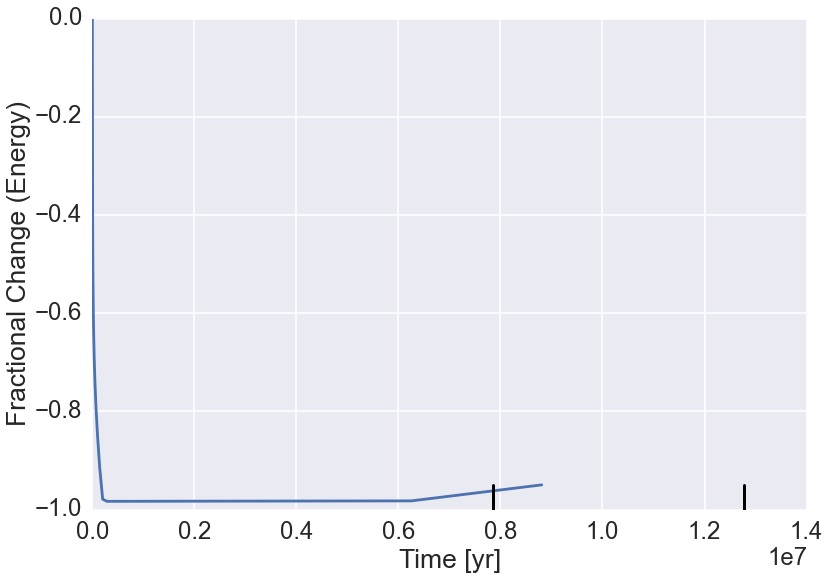

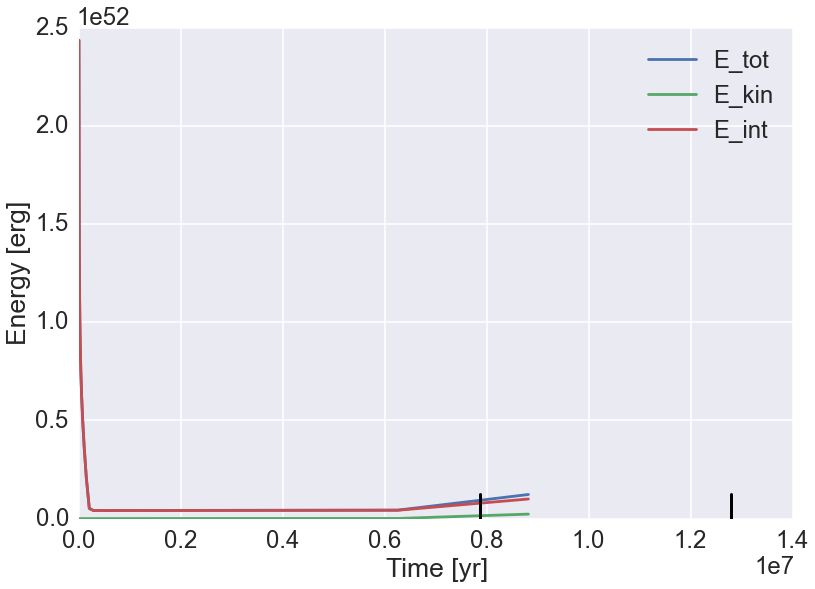

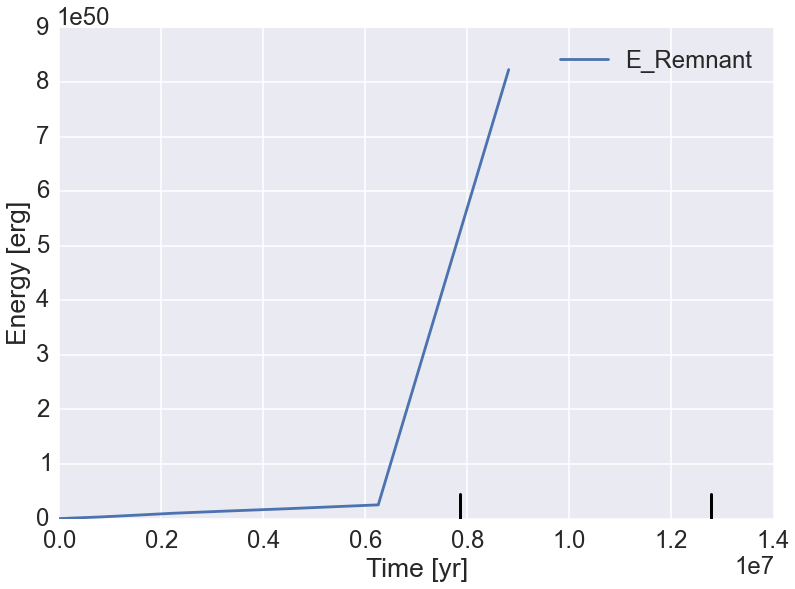

In [83]:
def plot_energy(last_run, x_axis):
    if type(last_run) is RunSummary:
        if ( (last_run.E_tot is not None) and
             (last_run.E_int is not None) and
             (last_run.E_kin is not None) ):
            
            plt.figure()
            
            if x_axis is "time":
                x_variable = last_run.times / yr
                xlabel = "Time [yr]"
                xscale = "linear"
                plt.xscale(xscale)
                xfmt = plt.gca().get_xaxis().get_major_formatter() # needs to be set AFTER plt.xscale()
                if xscale is "log":
                    mask = x_variable > 1
                elif xscale is "linear":
                    mask = np.full_like(x_variable, True, dtype=bool) 
                    xfmt.set_powerlimits((-2, 2)) # force scientific notation outside this range

            else:
                x_variable = np.arange(len(last_run.times))
                xlabel = "Checkpoint"
                xscale = "linear"
                mask = np.full_like(x_variable, True, dtype=bool) 

                plt.xscale(xscale)
                xfmt = plt.gca().get_xaxis().get_major_formatter() # needs to be set AFTER plt.xscale()
                
                
            
            E_err = (last_run.E_tot - last_run.E_tot[0]) / last_run.E_tot[0]
            plt.plot(x_variable[mask], E_err[mask])
            plt.xscale(xscale)
            plt.xlabel(xlabel)   
            plt.gca().xaxis.set_major_formatter(xfmt)
            plt.ylabel("Fractional Change (Energy)")
            SNe_distplot(last_run, x_axis)

            plt.figure()
            plt.plot(x_variable[mask], last_run.E_tot[mask], label="E_tot" )
            plt.plot(x_variable[mask], last_run.E_kin[mask], label="E_kin" )
            plt.plot(x_variable[mask], last_run.E_int[mask], label="E_int" )
            plt.legend(loc="best")
            plt.xscale(xscale)
            plt.xlabel(xlabel) 
            plt.gca().xaxis.set_major_formatter(xfmt)
            plt.ylabel("Energy [erg]")
            SNe_distplot(last_run, x_axis)

            
            plt.figure()
            plt.plot(x_variable[mask], last_run.E_R_tot[mask], label="E_Remnant" )
            plt.legend(loc="best")
            plt.xscale(xscale)
            plt.xlabel(xlabel)  
            plt.gca().xaxis.set_major_formatter(xfmt)
            plt.ylabel("Energy [erg]")
            SNe_distplot(last_run, x_axis)

            

            
interact(plot_energy,
         last_run=fixed(last_run),
         x_axis = RadioButtons(options=["time", "checkpoints"]))

None

<function __main__.plot_momentum>

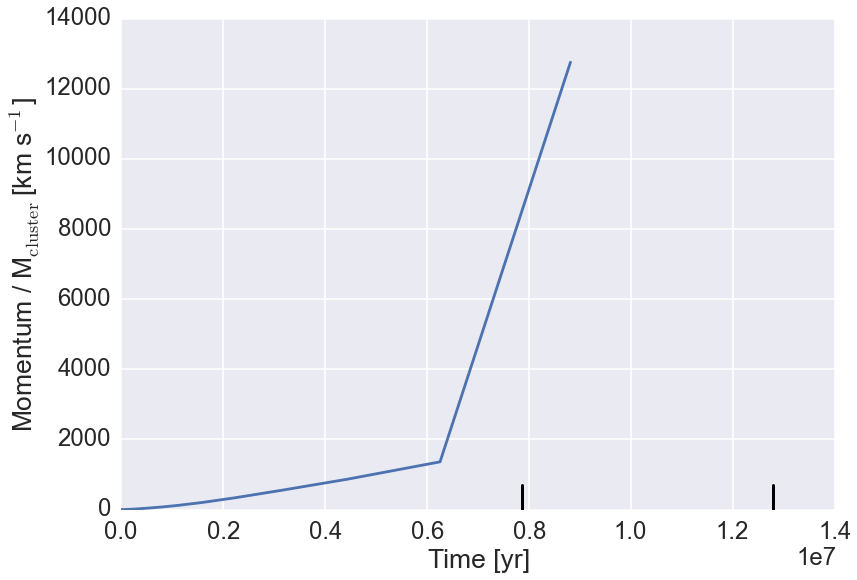

In [84]:
def plot_momentum(last_run, x_axis, clear_previous=True, distplot=True):
    if last_run.overview.cluster_mass <= 0:
        raise ValueError("Cluster mass doesn't allow valid normalization of momentum")
    if type(last_run) is RunSummary:
        if clear_previous:
            plt.figure()

        if x_axis is "time":
            x_variable = last_run.times / yr
            xlabel = "Time [yr]"
            xscale = "linear"
            plt.xscale(xscale)
            xfmt = plt.gca().get_xaxis().get_major_formatter() # needs to be set AFTER plt.xscale()
            if xscale is "log":
                mask = x_variable > 1
            elif xscale is "linear":
                mask = np.full_like(x_variable, True, dtype=bool) 
                xfmt.set_powerlimits((-2, 2)) # force scientific notation outside this range

        else:
            x_variable = np.arange(len(last_run.times))
            xlabel = "Checkpoint"
            xscale = "linear"
            mask = np.full_like(x_variable, True, dtype=bool) 

            plt.xscale(xscale)
            
            # needs to be set AFTER plt.xscale():
            xfmt = plt.gca().get_xaxis().get_major_formatter() 
        
        if distplot is True:
            SNe_distplot(last_run, x_axis)


        plt.plot(x_variable[mask], 
                 last_run.momentum[mask] / (last_run.overview.cluster_mass * 100*1000))
#         plt.plot(x_variable[mask], last_run.momentum[mask] )
        plt.xscale(xscale)
        plt.xlabel(xlabel)   
        plt.gca().xaxis.set_major_formatter(xfmt)
        plt.ylabel(r"Momentum / M$_\mathrm{cluster}$ [km s$^{-1}$]")
        
        plt.ylim(ymin=0)
        

            
interact(plot_momentum,
         last_run=fixed(last_run),
         x_axis = RadioButtons(options=["time", "checkpoints"]))

Luminosity max at checkpoint:  21
Luminosity max at time:        3.15e+06 [yr]


None

<function __main__.plot_luminosity>

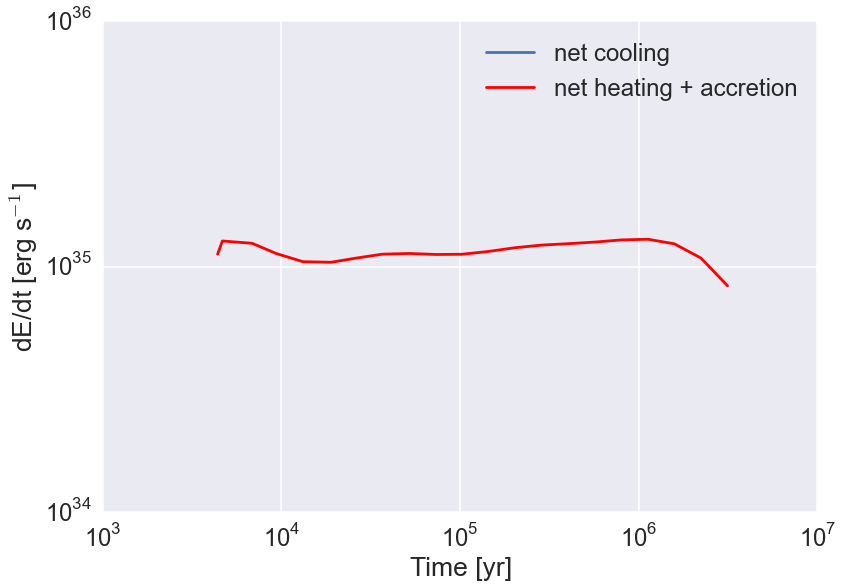

In [34]:
def plot_luminosity(last_run, x_axis):
    if type(last_run) is RunSummary:
        plt.figure()
        if x_axis is "time":
            x_variable = last_run.times / yr
            xlabel = "Time [yr]"
            xscale = "log"
            if xscale is "log":
                mask = x_variable > 1
            else:
                mask = np.full_like(x_variable, True, dtype=bool)
                xfmt.set_powerlimits((-2, 2)) # force scientific notation outside this range

        else:
            x_variable = np.arange(len(last_run.times))
            xlabel = "Checkpoint"
            xscale = "linear"
            mask = np.full_like(x_variable, True, dtype=bool)
        
        y_data = last_run.Luminosity[mask]
        gauss_kernel = Gaussian1DKernel(2)
        y_data = convolve(y_data, gauss_kernel)
        
        plt.plot(x_variable[mask],  y_data, label="net cooling")
        plt.plot(x_variable[mask], -y_data, label="net heating + accretion", color="r")
        plt.xlabel(xlabel)
        plt.xscale(xscale)
        plt.ylabel(r"dE/dt [erg s$^{-1}$]")
        plt.yscale("log")
        plt.legend(loc="best")
        
        xfmt = plt.gca().get_xaxis().get_major_formatter()

        plt.gca().xaxis.set_major_formatter(xfmt)
        print("Luminosity max at checkpoint: ", np.argmax(last_run.t_0 == last_run.times))
        print("Luminosity max at time:       ", "%0.2e" % (last_run.t_0 / yr), "[yr]" )


interact(plot_luminosity,
         last_run=fixed(last_run),
         x_axis = RadioButtons(options=["time", "checkpoints"]))


In [36]:
ids_1e2_M_solar = ["2177f", "0590d", "639be"]
ids_1e3_M_solar = ["7247a", "ff5b5", "de6b1"]
ids_1e4_M_solar = ["30faf", "cccbd", "c390f"]
ids_1e5_M_solar = ["2bf32", "46aed", "fa9c8"]

def mass_loss_comparisons_last_checkpoint(ids, data_dir="../src"):
    
    plt.figure()
    if not os.path.exists(data_dir):
        raise FileNotFoundError("No directory found named: "+ data_dir)
    
    last_run = RunSummary()
    mass_loss_labels = []
    
    for id in ids:
    
        parse_results = parse_run(data_dir=data_dir, id=id, last_run=last_run)
        sedov_solution = SedovSolution(E_0,
                                       last_run.overview.background_density, 
                                       last_run.overview.metallicity)

        #### PASS TO PLOTTER ####
        num_checkpoints = len(parse_results.checkpoint_filenames)

        log_R_max = round(np.log10(last_run.df["Radius"].max()), 2)
        log_R_min = max(log_R_max-4, 
                        round(np.log10(last_run.df["Radius"].min()), 2)+1)


        plt.title("%.0e" % (last_run.overview.cluster_mass / M_solar) + r" $M_\odot$ cluster" )
    #              + "\n" + "Mass loss prescription: " + last_run.overview.mass_loss)    
        plotter(last_run,
                parse_results.checkpoint_filenames, 
                last_run.overview.metallicity, 
                last_run.overview.background_density, 
                last_run.overview.background_temperature,
                sedov_solution,
                x_axis_variable  = "Radius",
                y_axis_variable  = "Density",
                with_Sedov       = False,
                highlight_timestep_limiting_cell = False,
                outer_limit_log  = log_R_max, 
                checkpoint_index = num_checkpoints-1,
                show_at_end = False)
        mass_loss_labels.append(last_run.overview.mass_loss)


    plt.legend(mass_loss_labels, loc="best", title="mass loss")

    plot_filename = "plots/last_checkpoint_%.0e_Msun" % (last_run.overview.cluster_mass / M_solar)
    plt.savefig(plot_filename + ".eps")
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    clear_output()

def mass_loss_comparisons_before_second_blast(ids, data_dir="../src"):
    
    plt.figure()
    if not os.path.exists(data_dir):
        raise FileNotFoundError("No directory found named: "+ data_dir)
    
    last_run = RunSummary()
    mass_loss_labels = []
    
    for id in ids:
    
        parse_results = parse_run(data_dir=data_dir, id=id, last_run=last_run)
        sedov_solution = SedovSolution(E_0,
                                       last_run.overview.background_density, 
                                       last_run.overview.metallicity)

        #### PASS TO PLOTTER ####
        num_checkpoints = len(parse_results.checkpoint_filenames)
        plot_checkpoint = np.argmin(last_run.times < last_run.overview.SNe_times[1]) - 1

        log_R_max = round(np.log10(last_run.df["Radius"].max()), 2)
        log_R_min = max(log_R_max-4, 
                        round(np.log10(last_run.df["Radius"].min()), 2)+1)


        plt.title("%.0e" % (last_run.overview.cluster_mass / M_solar) + r" $M_\odot$ cluster" )
    #              + "\n" + "Mass loss prescription: " + last_run.overview.mass_loss)    
        plotter(last_run,
                parse_results.checkpoint_filenames, 
                last_run.overview.metallicity, 
                last_run.overview.background_density, 
                last_run.overview.background_temperature,
                sedov_solution,
                x_axis_variable  = "Radius",
                y_axis_variable  = "Density",
                with_Sedov       = False,
                highlight_timestep_limiting_cell = False,
                outer_limit_log  = log_R_max, 
                checkpoint_index = plot_checkpoint,
                show_at_end = False)
        mass_loss_labels.append(last_run.overview.mass_loss)


    plt.legend(mass_loss_labels, loc="best", title="mass loss")

    plot_filename = "plots/before_second_blast_%.0e_Msun" % (last_run.overview.cluster_mass / M_solar)
    plt.savefig(plot_filename + ".eps")
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    clear_output()

def mass_loss_comparisons_momentum(ids, data_dir="../src"):
    
    plt.figure()
    if not os.path.exists(data_dir):
        raise FileNotFoundError("No directory found named: "+ data_dir)
    
    last_run = RunSummary()
    mass_loss_labels = []

    for id in ids:
    
        parse_results = parse_run(data_dir=data_dir, id=id, last_run=last_run)
        sedov_solution = SedovSolution(E_0,
                                       last_run.overview.background_density, 
                                       last_run.overview.metallicity)

        #### PASS TO PLOTTER ####
        num_checkpoints = len(parse_results.checkpoint_filenames)

        log_R_max = round(np.log10(last_run.df["Radius"].max()), 2)
        log_R_min = max(log_R_max-4, 
                        round(np.log10(last_run.df["Radius"].min()), 2)+1)


        plt.title("%.0e" % (last_run.overview.cluster_mass / M_solar) + r" $M_\odot$ cluster" )
    #              + "\n" + "Mass loss prescription: " + last_run.overview.mass_loss)   
    
        plot_momentum(last_run, "time", clear_previous=False, distplot=False)
        mass_loss_labels.append(last_run.overview.mass_loss)


    plt.legend(mass_loss_labels, loc="best", title="mass loss")
    SNe_distplot(last_run, "time")

    plot_filename = "plots/momentum_%.0e_Msun" % (last_run.overview.cluster_mass / M_solar)
    plt.savefig(plot_filename + ".eps")
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    clear_output()

    
    
def mass_loss_comparisons_R_shock(ids, data_dir="../src"):
    
    plt.figure()
    if not os.path.exists(data_dir):
        raise FileNotFoundError("No directory found named: "+ data_dir)
    
    last_run = RunSummary()
    mass_loss_labels = []
    
    for id in ids:
    
        parse_results = parse_run(data_dir=data_dir, id=id, last_run=last_run)

        plt.title("%.0e" % (last_run.overview.cluster_mass / M_solar) + r" $M_\odot$ cluster" )
        shock_location_plot(last_run, clear_previous=False, distplot=False)
        mass_loss_labels.append(last_run.overview.mass_loss)

    plt.legend(mass_loss_labels, loc="best", title="mass loss")
    clear_output()
    SNe_distplot(last_run, "time")
    
    plot_filename = "plots/R_shock_%.0e_Msun" % (last_run.overview.cluster_mass / M_solar)
    plt.savefig(plot_filename + ".eps")
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")

mass_loss_comparisons_before_second_blast(ids=ids_1e2_M_solar)

    
mass_loss_comparisons_last_checkpoint(ids_1e2_M_solar)
mass_loss_comparisons_last_checkpoint(ids_1e3_M_solar)
mass_loss_comparisons_last_checkpoint(ids_1e4_M_solar)
mass_loss_comparisons_last_checkpoint(ids_1e5_M_solar)

mass_loss_comparisons_momentum(ids_1e2_M_solar)
mass_loss_comparisons_momentum(ids_1e3_M_solar)
mass_loss_comparisons_momentum(ids_1e4_M_solar)
mass_loss_comparisons_momentum(ids_1e5_M_solar)

mass_loss_comparisons_R_shock(ids_1e2_M_solar)
mass_loss_comparisons_R_shock(ids_1e3_M_solar)
mass_loss_comparisons_R_shock(ids_1e4_M_solar)
mass_loss_comparisons_R_shock(ids_1e5_M_solar)




FileNotFoundError: No checkpoints found